In [2]:
import numpy as np
import os
import cv2
import mediapipe as mp
import subprocess
import csv
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.layers import Input,Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae_func, mean_squared_error
from sklearn import preprocessing
mp_selfie_segmentation = mp.solutions.selfie_segmentation
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
# print(cv2.getBuildInformation())

In [4]:
video_directory = "E:\\course_work\\Dissertation\\back"

videos = []

for dirpath, dirnames, filenames in os.walk(video_directory):
    video_files = [file for file in filenames if file.endswith('.mkv')]
    for video_file in video_files:
        video_file_path = os.path.join(dirpath, video_file)
        output_file_path = os.path.splitext(video_file_path)[0] + '.mp4'
        subprocess.run(['ffmpeg', '-i', video_file_path, output_file_path])
        videos.append(output_file_path)


In [5]:
  
output_folder = "E:\\course_work\\Dissertation\\pose_estim\\" 
output_extension = ".mp4"

# Set the video writer parameters
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Specify the video codec (e.g., "mp4v" for MP4)

frame_size = (1280, 720)



# Estimation Keypoint

<img src="https://www.mdpi.com/applsci/applsci-13-02700/article_deploy/html/images/applsci-13-02700-g001.png" style="height=200px" >

# Jumping

In [6]:
def calculate_vertical_displacement(a, b):
    """Calculate the vertical displacement between points a and b"""
    return b - a

# Squating

In [7]:
def calculate_angle(a, b, c):
    """Calculate the angle between points a, b, and c"""
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    #cosine_angle = np.clip(cosine_angle, -1, 1)
    angle = np.arccos(cosine_angle)
    
    return np.degrees(angle)

In [31]:
os.makedirs(output_folder, exist_ok=True)
csv_file = open("output.csv", mode='w', newline='')  # Set newline='' to avoid extra empty rows
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['video_path', 'action', 'hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle','feet_together'])

feet_together = False

with mp_pose.Pose(min_detection_confidence=0.8 , min_tracking_confidence=0.8) as pose,mp_selfie_segmentation.SelfieSegmentation(model_selection=0) as selfie_segmentation:
    for vid in videos:
        video = cv2.VideoCapture(vid)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        squat_detected = False
        jump_detected = False
        baseline = None
        jump_threshold = 0.015
        filename = os.path.splitext(os.path.basename(vid))[0]
        output_path = os.path.join(output_folder, filename + output_extension)
        original_fps = video.get(cv2.CAP_PROP_FPS)
        original_frame_size = (
            int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )
        video_writer = cv2.VideoWriter(output_path, fourcc, original_fps, frame_size)
        hip_knee_angles = []
        shoulder_hip_angles = []
        shoulder_angles = []
        elbow_angles = []
        foot_y_positions = []
        avg_hip_angle = 0.0
        avg_shoulder_angle = 0.0
        avg_knee_angle = 0.0
        frame_count = 0
        feet_off_floor = False
        feet_landed = False
        while True:
            ret,frame = video.read()
            if not ret:
                break

            resized_frame = cv2.resize(frame, frame_size)
            image = cv2.cvtColor(resized_frame,cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = pose.process(image)
            segmentation_results = selfie_segmentation.process(image)
            image.flags.writeable = True
            
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark

                # Squating
                right_hip = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y])
                right_knee = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y])
                left_knee = np.array([landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y])
                right_shoulder = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y])
                left_shoulder = np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y])
                left_hip = np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP].y])
                right_elbow = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y])
                right_wrist = np.array([landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y])
                right_foot_y = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y
                left_foot_y = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y
                right_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE].y
                left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y
                
                # Calculate angles
                elbow_angle = calculate_angle(right_shoulder, right_elbow, right_wrist)
                hip_knee_angle = calculate_angle(right_hip, right_knee, left_knee)
                shoulder_hip_angle = calculate_angle(right_shoulder, right_hip, left_hip)
                shoulder_angle = calculate_angle(right_shoulder, left_shoulder, right_hip)
                
                
                hip_knee_angles.append(hip_knee_angle)
                shoulder_hip_angles.append(shoulder_hip_angle)
                shoulder_angles.append(shoulder_angle)
                elbow_angles.append(elbow_angle)
                avg_hip_angle += hip_knee_angle
                avg_shoulder_angle += shoulder_hip_angle
                avg_knee_angle += shoulder_angle
    
                
                # Detect squats
                squat_condition1 = hip_knee_angle < 110
                squat_condition2 = shoulder_hip_angle < 130
                squat_condition3 = shoulder_angle < 70
                squat_condition4 = elbow_angle > 90
                squat_condition5 = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y >= landmarks[mp_pose.PoseLandmark.RIGHT_KNEE].y
                squat_condition6 = landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y >= landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y
                if squat_condition1 and squat_condition2 and squat_condition3 and squat_condition4 and squat_condition5 and squat_condition6:  # Ensuring heels are grounded
                    squat_detected = True
                
            
                # Jumping

                hip_y = (landmarks[27].y + landmarks[28].y) / 2
    
                if baseline is None:
                    baseline = hip_y
                else:
                    # Calculate the distance of the hips from the baseline
                    hip_distance = calculate_vertical_displacement(baseline,hip_y)

                    if hip_distance > jump_threshold :
                        jump_detected = True
                        
                        average_foot_y = (right_foot_y + left_foot_y) / 2
                        foot_y_positions.append(average_foot_y)
                        if len(foot_y_positions) > 2:
                            prev_pos1 = foot_y_positions[-3]
                            prev_pos2 = foot_y_positions[-2]
                            curr_pos = foot_y_positions[-1]
                            print(prev_pos1)
                            print(prev_pos)
                            

                    # Check if both feet were previously on the floor and are now off the floor
                            if prev_pos1 < prev_pos2 and curr_pos < prev_pos2:
                                feet_off_floor = True

                            if prev_pos1 > prev_pos2 and curr_pos > prev_pos2 and feet_off_floor:
                                feet_landed = True

                            if feet_off_floor and feet_landed:
                                feet_together = True
                    baseline = hip_y
                    

                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                #Frame Normalization
                landmarks_array = np.array([(lmk.x, lmk.y, lmk.z) for lmk in landmarks])
                # Normalize the landmarks
                mean = np.mean(landmarks_array, axis=0)
                std = np.std(landmarks_array, axis=0)
                normalized_landmarks = (landmarks_array - mean) / std

            condition = np.stack((segmentation_results.segmentation_mask,) * 3, axis=-1) > 0.1
            # this two will blurred background 
            blurred_image = cv2.GaussianBlur(image, (99, 99), 30)
            output_image = np.where(condition, image, blurred_image)

            # this below lines change background to green color
            # background_color = np.zeros_like(image)
            # background_color[:] = [0, 255, 0]  # Green in BGR
            # output_image = np.where(condition, image, background_color)
            
            frame_count += 1

            video_writer.write(output_image)
            
        hip_knee_angle = np.mean(hip_knee_angles)
        shoulder_hip_angle = np.mean(shoulder_hip_angles)
        shoulder_angle = np.mean(shoulder_angles)
        elbow_angle = np.mean(elbow_angles)
        
        if frame_count > 0:
            avg_hip_angle /= frame_count
            avg_shoulder_angle /= frame_count
            avg_knee_angle /= frame_count
        else:
            # Assign default values if no frames were processed
            avg_hip_angle = 0.0
            avg_shoulder_angle = 0.0
            avg_knee_angle = 0.0
            
        if squat_detected and not jump_detected:
            action = "Squat"
            print(f"Squat detected in video: {vid}")
        elif jump_detected and squat_detected:
            action= "Jump"
            print(f"Jump detected in video: {vid}")
        else:
            action='None'
        print(int(feet_together))
        csv_writer.writerow([output_path, action, hip_knee_angle, shoulder_hip_angle, shoulder_angle, elbow_angle,avg_hip_angle,avg_shoulder_angle,avg_knee_angle,int(feet_together)])
        # else:
        #     print(f"nothing detected in video: {vid}")
        video.release()
        video_writer.release()
csv_file.close()



Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094505.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094600.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094626.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094649.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094705.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094722.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094739.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094754.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094811.mp4
0
Squat detected in video: E:\course_work\Dissertation\back\back_001\back_001_m01_20230224094

KeyboardInterrupt: 

In [5]:
import pandas as pd

In [6]:
import cv2
import numpy as np

def preprocess_video(video_path, frame_size=(64, 64), num_frames=30):
    # Initialize a list to hold frames
    frames = []

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the middle frame number
    middle_frame = total_frames // 2

    # Calculate the start frame number
    start_frame = max(0, middle_frame - num_frames // 2)

    # Set the video to start at the start_frame
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while True:
        # Read a frame from the video
        ret, frame = video.read()

        # If the frame was successfully read
        if ret:
            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Normalize pixel values
            frame = frame / 255.0

            # Add the frame to the list
            frames.append(frame)
        else:
            # If no frame was read then we've reached the end of the video
            break

        # If we've collected enough frames then we can stop reading the video
        if len(frames) == num_frames:
            break

    video.release()

    # Stack frames into a single numpy array
    frames = np.stack(frames)

    return frames



In [7]:
# Read the CSV file
data = pd.read_csv('output.csv')
label_encoder = preprocessing.LabelEncoder()
data['action']= label_encoder.fit_transform(data['action'])
data  = data.dropna()

# Preprocess videos
video_X = np.array([preprocess_video(vp) for vp in data['video_path']])

angle_X = data[['hip_knee_angle', 'shoulder_hip_angle', 'shoulder_angle', 'elbow_angle','avg_hip_angle', 'avg_shoulder_angle', 'avg_knee_angle','action']].values

# Convert the scores to a numpy array
y = data['score'].values


In [8]:
# Split the video data into training and testing sets
video_X_train, video_X_test, y_train, y_test = train_test_split(video_X, y, test_size=0.2, random_state=42)

# Split the angle data into training and testing sets
angle_X_train, angle_X_test, _, _ = train_test_split(angle_X, y, test_size=0.2, random_state=42)

# Define the model
num_frames = video_X_train.shape[1]
frame_height = video_X_train.shape[2]
frame_width = video_X_train.shape[3]
num_channels = video_X_train.shape[4]
num_angles = angle_X_train.shape[1]

In [9]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))
x = Conv3D(32, (3, 3, 3), activation='relu')(video_input)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

In [10]:
# Angles branch
angles_input = Input(shape=(num_angles,))
y = Dense(32, activation='relu')(angles_input)

In [11]:
combined = Concatenate()([x, y])

In [12]:
# combined outputs
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)
score_output = Dense(1, activation='linear')(z)

In [13]:
model = Model(inputs=[video_input, angles_input], outputs=score_output)

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])


# Train the model
history = model.fit([video_X_train, angle_X_train], y_train, validation_data=([video_X_test, angle_X_test], y_test), epochs=10, batch_size=32)


# Evaluate the model
loss, mean_absolute_error = model.evaluate([video_X_test, angle_X_test], y_test)
predictions = model.predict([video_X_test, angle_X_test])


mae = mae_func(y_test, predictions)


rmse = mean_squared_error(y_test, predictions, squared=False)

print("Mean Absolute Error: {:.4f}".format(mae))
print("Root Mean Squared Error: {:.4f}".format(rmse))



Epoch 1/10
6/6 [==============================] - 71s 11s/step - loss: 148.5798 - mean_absolute_error: 8.4549 - val_loss: 8.1390 - val_mean_absolute_error: 2.6410
Epoch 2/10
6/6 [==============================] - 64s 10s/step - loss: 3.6553 - mean_absolute_error: 1.4772 - val_loss: 1.0724 - val_mean_absolute_error: 0.8062
Epoch 3/10
6/6 [==============================] - 66s 11s/step - loss: 1.3723 - mean_absolute_error: 0.9628 - val_loss: 0.5070 - val_mean_absolute_error: 0.6181
Epoch 4/10
6/6 [==============================] - 63s 10s/step - loss: 0.5969 - mean_absolute_error: 0.6032 - val_loss: 0.5542 - val_mean_absolute_error: 0.6509
Epoch 5/10
6/6 [==============================] - 62s 10s/step - loss: 0.6902 - mean_absolute_error: 0.6673 - val_loss: 0.4645 - val_mean_absolute_error: 0.5807
Epoch 6/10
6/6 [==============================] - 61s 10s/step - loss: 0.5403 - mean_absolute_error: 0.6061 - val_loss: 0.4590 - val_mean_absolute_error: 0.5777
Epoch 7/10
6/6 [================

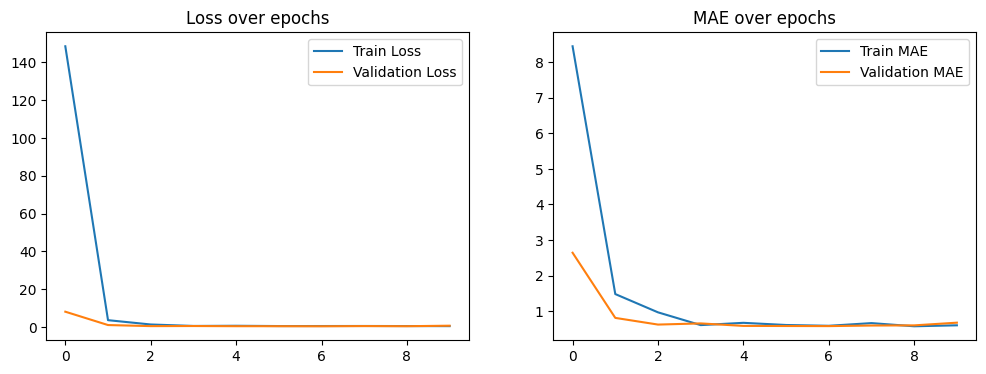

In [15]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE over epochs')
plt.legend()

plt.show()

In [18]:
for i in range(len(predictions)):
    print("Predicted: | Actual: ".format(predictions[i][0], y_test[i]))

Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 
Predicted: | Actual: 


## Another Model

In [19]:
# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)

    # Shared convolutional layers
    conv1 = Conv3D(32, (3, 3, 3), activation='relu')
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))
    flatten = Flatten()

    # Branch 1
    x1 = conv1(input_1)
    x1 = pool1(x1)
    x1 = flatten(x1)

    # Branch 2
    x2 = conv1(input_2)
    x2 = pool1(x2)
    x2 = flatten(x2)

    # Concatenate the outputs of the branches
    merged = Concatenate()([x1, x2])

    # Dense layers for final prediction
    x = Dense(64, activation='relu')(merged)
    output = Dense(1, activation='linear')(x)

    # Create the Siamese model
    siamese_model = Model(inputs=[input_1, input_2], outputs=output)

    return siamese_model

In [20]:
input_shape = (num_frames, frame_height, frame_width, num_channels)

In [21]:
siamese_model = create_siamese_network(input_shape)

In [22]:
siamese_model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
his = siamese_model.fit([video_X_train, video_X_train], y_train, epochs=10, batch_size=32, validation_data=([video_X_test, video_X_test], y_test))

Epoch 1/10
6/6 [==============================] - 88s 13s/step - loss: 8997.4561 - val_loss: 79.1168
Epoch 2/10
6/6 [==============================] - 82s 13s/step - loss: 134.6432 - val_loss: 46.6761
Epoch 3/10
6/6 [==============================] - 82s 13s/step - loss: 14.3274 - val_loss: 5.9933
Epoch 4/10
6/6 [==============================] - 80s 13s/step - loss: 8.1760 - val_loss: 0.5772
Epoch 5/10
6/6 [==============================] - 81s 13s/step - loss: 2.8445 - val_loss: 0.5323
Epoch 6/10
6/6 [==============================] - 81s 13s/step - loss: 1.8148 - val_loss: 2.4140
Epoch 7/10
6/6 [==============================] - 77s 13s/step - loss: 1.4635 - val_loss: 1.7192
Epoch 8/10
6/6 [==============================] - 77s 13s/step - loss: 1.1621 - val_loss: 1.0134
Epoch 9/10
6/6 [==============================] - 81s 13s/step - loss: 0.8881 - val_loss: 0.4530
Epoch 10/10
6/6 [==============================] - 80s 13s/step - loss: 0.5410 - val_loss: 1.0869


In [24]:
predictions = siamese_model.predict([video_X_test, video_X_test])

# Calculate mean absolute error (MAE)
mae = mae_func(y_test, predictions)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(y_test, predictions, squared=False)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))

2/2 [==============================] - 3s 841ms/step
Mean Absolute Error: 0.84
Root Mean Squared Error: 1.04


KeyError: 'mean_absolute_error'

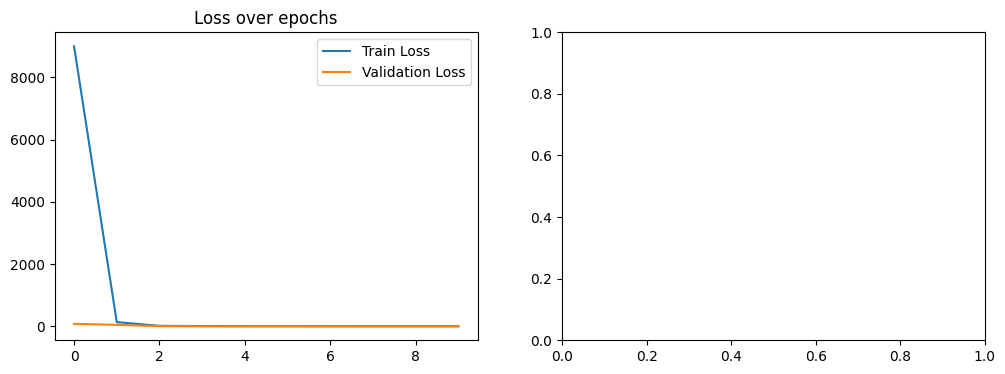

In [26]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(his.history['loss'], label='Train Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(his.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE over epochs')
plt.legend()

plt.show()